This notebook demonstrates the basic features of the `nbgwas` package.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import nbgwas
from nbgwas import Nbgwas
import numpy as np
import pandas as pd

In [3]:
nbgwas.__version__

'0.4.1rc5'

# Gathering data

This package is flexible enough for nearly any GWAS summary statistics for any species, as long as the data is encoded in a table format. For this tutorial, we will use the data that is available on the <a href='http://nbgwas.ucsd.edu/nagadata'>package's companion website</a>. 

In [4]:
snp_level_summary_url = 'http://nbgwas.ucsd.edu/nagadata/schizophrenia.txt'
protein_coding_url = 'http://nbgwas.ucsd.edu/nagadata/protein_coding/hg18.txt'

snp_level_summary_df = pd.read_csv(snp_level_summary_url, sep='\s+')
#snp_level_summary_df = tmp_snp_summary.rename(index=str, columns={"chromosome": "hg18chr", "basepair": "bp", "pvalue": "pval"})
protein_coding_df = pd.read_csv(protein_coding_url, sep='\s+', names=['Chrom', 'Start', 'End'], index_col=0)

Here is what they look like. 

In [5]:
snp_level_summary_df.head()

,snpid,chromosome,basepair,a1,a2,or,se,pvalue,info,ngt,CEUaf
0,rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.16055
1,rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
2,rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,.
3,rs1048488,1,750775,T,C,0.9749,0.0835,0.761041,0.1613,0,0.836449
4,rs12562034,1,758311,A,G,1.0011,0.0756,0.987899,0.1856,3,0.0925926


In [6]:
protein_coding_df.head()

,Chrom,Start,End
A1BG,19,63551643,63565932
A1CF,10,52271589,52315441
A2M,12,9111570,9159825
A2ML1,12,8911704,8930864
A3GALT2,1,33544953,33559286


# Working with SNP and Genes Tables

`Nbgwas` requires two major components to work properly--**gene level summary** that contains p-values from genes, available from the `Genes` object, and a **network** that describes how the genes are connected, available from the `Network` objects. For genome wide association studies (GWAS), genomic information will be at the single nucleotide level. `Nbgwas` contains a class called `Snps` to handle this case.  

To gain access to the these internal objects, first instantiate the `Nbgwas` client by calling the constructor. If you have gene level information in the form of `pandas` Dataframe and a network in either `networkx` or `igraph` object, you can provide these to the constructor as well. See the manual or use the `help` function for more information. 

In [7]:
g = Nbgwas()

print(g.snps)
print(g.genes)
print(g.network)

<Snps> object
<Genes> object containing 0 genes


Note that by instantiating the client, you will gain access to the all the methods asscoiated with the necessary objects even if there is no internal data. 

To load a SNP level summary, you can use the `from_file` method from the `snps` attribute. In order for `Nbgwas` to interpret the SNP locations, protein coding tables must also be provided along with the SNP table. The protein coding table describes where the locations on the genome so that `Nbgwas` can determine which of the coding gene, if any, a gene is closest to. All keyword arguments to pandas `read_csv` can be supplied as a keyword dictionary using `snp_kwargs` and `pc_kwargs`.

You can create an `Nbgwas` object using the constructor as well. 

In [8]:
g = Nbgwas(
    snp_level_summary=snp_level_summary_df, 
    snp_chrom_col="chromosome", 
    bp_col="basepair", 
    snp_pval_col="pvalue",
    
    protein_coding_table = protein_coding_df    
)

To map SNPs to genes, you can use the `assign_snps_to_genes` in the `Snps` object.

In [9]:
g.genes = g.snps.assign_snps_to_genes(window_size=10000, to_Gene=True)

Alternatively, you can provide your own gene level summary that has mapped single nucleotide polymorphisms to genes. Note, doing this will overwrite the existing gene level summary. To load a gene level summary, use the `from_file` method associated with the `Genes` object which is pre-instantiated in Nbgwas `genes` attribute. This method allows the user to provide any keyword arguments associated with the `pandas` `read_csv` function. Additionally, the user needs to provide the column name associated with the p-values (`pval_col`) and gene name (`name_col`).

In [10]:
gene_level_summary_file = 'http://nbgwas.ucsd.edu/nagadata/example_input/gene_level_summary_stats_pmid_25056061.txt'

g.genes.from_file(
    gene_level_summary_file, 
    sep='\t', index_col=0, 
    pval_col='TopSNP P-Value', 
    name_col='Gene'
)

<Genes> object containing 14966 genes

This table is loaded to the `table` attribute and can be accessed as follows. 

In [11]:
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
5867,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
5883,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
5868,HIST1H2AL,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
5855,HIST1H1B,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


In order to convert the p-values to heat, you can use the `convert_to_heat` method associated with the `Genes` object. The result is appended to the table. 

In [12]:
g.genes.convert_to_heat(method='binarize', name='Binarized Heat')
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0,1.0
2009,CCDC39,3,181908070,182070660,56,rs1879248,182033908.0,1.272380e-06,125838.0,1.0
12335,SLC17A3,6,25953306,25982450,37,rs9461219,25944906.0,4.003060e-07,8400.0,1.0
1416,BTN3A2,6,26476384,26484953,42,rs1978,26485552.0,4.755630e-07,9168.0,1.0
1414,BTN2A2,6,26491441,26503079,43,rs1978,26485552.0,4.755630e-07,5889.0,1.0


In [13]:
g.genes.convert_to_heat(method='neg_log', name='Negative Log')
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat,Negative Log
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0,1.0,21.402277
5867,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0,1.0,21.402277
5883,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0,1.0,21.402277
5893,HIST1H3I,6,27947601,27948078,10,rs13199772,27942064.0,7.053790e-10,5537.0,1.0,21.072286
5906,HIST1H4L,6,27948904,27949268,10,rs13199772,27942064.0,7.053790e-10,6840.0,1.0,21.072286


# Adding Networks

Now that we have all the genes associated information, we can now load a network to enable a network analysis of the genes information. Like the methods associated with `Genes`, all network related methods is available in `network` attribute. There are many ways to load a network, including reading a serialized `networkx` object using `from_pickle`, pulling a network from NDex using `from_ndex`, or reading from a flat CX file using `from_cx`. If you already have a `networkx` or `igraph` graph, you can add it directly to the network using `client.network = myGraph`.

In [14]:
g.network.from_ndex('f93f402c-86d4-11e7-a10d-0ac135e8bacf') #PCNet

You can access node attributes using the `node_table`. Right now, it only contains the name for each gene. This table will contain the results of the network propagation later. 

In [15]:
g.network.node_table.head()

,name
0,UBE2Q1
1,RNF14
2,UBE2Q2
3,RNF10
4,RNF11


In order to move data from the `Genes` table to the `Network`'s `node_table`, you can use `map_to_node_table` method where you can specify the specific columns to map onto the network's node attributes. 

In [16]:
g.map_to_node_table(columns=['Binarized Heat', 'Negative Log'])
g.network.node_table.head()

,name,Binarized Heat,Negative Log
0,UBE2Q1,0.0,3.049072
1,RNF14,0.0,3.184936
2,UBE2Q2,0.0,1.235095
3,RNF10,0.0,2.250201
4,RNF11,0.0,1.908012


# Network Propagation

From there, the information is available for network propagation. 

In [17]:
g.diffuse(method='random_walk', node_attribute='Binarized Heat', result_name='Diffused (Binarized)')
g.network.node_table.head()

/cellar/users/samsonfong/Ongoing/nbgwas_package/nbgwas/propagation.py:57: UserWarning: Forcing F0 to be sparse
  warnings.warn("Forcing F0 to be sparse")


,name,Binarized Heat,Negative Log,Diffused (Binarized)
15215,TCF4,1.0,14.399194,0.479835
14802,HIST1H4C,1.0,14.533063,0.467925
7301,HIST1H2BC,1.0,14.820414,0.467749
7304,HIST1H2BN,1.0,21.402277,0.466517
14811,HIST1H4J,1.0,14.887917,0.466316


In [18]:
g.diffuse(method='random_walk', node_attribute='Negative Log', result_name='Diffused (Log)')
g.network.node_table.head()

/cellar/users/samsonfong/Ongoing/nbgwas_package/nbgwas/propagation.py:57: UserWarning: Forcing F0 to be sparse
  warnings.warn("Forcing F0 to be sparse")


,name,Binarized Heat,Negative Log,Diffused (Binarized),Diffused (Log)
8466,UBC,0.0,1.730928,0.078809,90.492111
341,APP,0.0,11.557914,0.017122,33.418802
1079,HNF4A,0.0,1.239945,0.025469,23.489276
4787,TAF1,0.0,0.000000,0.035881,23.222991
1149,PRKACB,0.0,2.404228,0.007903,23.139555


In [ ]:
g.diffuse(method='heat_diffusion', node_attribute='Negative Log', result_name='Diffused (Heat, Log)')
g.network.node_table.head()

In [ ]:
g.diffuse(method='heat_diffusion', node_attribute='Binarized Heat', result_name='Diffused (Heat, Binarize)')
g.network.node_table.head()

To sync the information from the node table to node attributes, use the `refresh_node_attributes` method.

In [ ]:
g.network.refresh_node_attributes()

# Viewing and Interacting with Networks

/cellar/users/samsonfong/Ongoing/nbgwas_package/nbgwas/network.py:457: UserWarning: The specified graph does not have the attribute Diffused (Binarize). Replacing values with 0.
  "The specified graph does not have the attribute %s. Replacing values with 0." % attributes
/cellar/users/samsonfong/bin/anaconda3/envs/nbgwas2/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/cellar/users/samsonfong/bin/anaconda3/envs/nbgwas2/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/cellar/users/samsonfong/bin/anaconda3/envs/nbgwas2/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: T

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54704020b8>)

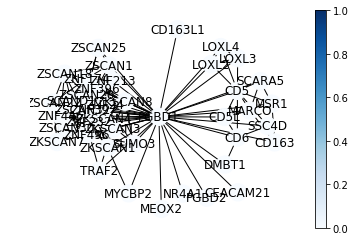

In [46]:
g.network.local_neighborhood(center_name='PGBD1', neighbors=1).view(attributes='Diffused (Binarize)', vmin=0, vmax=1)

`Nbgwas` also supports viewing and interacting with networks in Cytoscape. To do so, make sure Cytoscape is opened in the background (and make sure you have a version that supports CyRest). We have tested versions 3.6 and 3.7. 

In [47]:
g.network.local_neighborhood(center_name='PGBD1', neighbors=1).view_in_cytoscape()

ConnectionError: HTTPConnectionPool(host='localhost', port=1234): Max retries exceeded with url: /v1/styles/visualproperties (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f54700a79b0>: Failed to establish a new connection: [Errno 111] Connection refused',))

# Evaluating Performance

In [109]:
with open('../../nbgwas_analysis/data/gold_standards/SZ_hugo_genes_only.txt') as f: 
    gold_standard = [i.strip() for i in f.readlines()]

In [110]:
g.genes.table.head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat,Negative Log
5905,HIST1H4K,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0,1.0,21.402277
5867,HIST1H2AK,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0,1.0,21.402277
5883,HIST1H2BN,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0,1.0,21.402277
5893,HIST1H3I,6,27947601,27948078,10,rs13199772,27942064.0,7.053790e-10,5537.0,1.0,21.072286
5906,HIST1H4L,6,27948904,27949268,10,rs13199772,27942064.0,7.053790e-10,6840.0,1.0,21.072286


In [113]:
g.map_to_gene_table(columns=['Diffused (Log)'])

Index(['Gene', 'Chr', 'Gene Start', 'Gene End', 'nSNPs', 'TopSNP',
       'TopSNP Pos', 'TopSNP P-Value', 'SNP Distance', 'Binarized Heat',
       'Negative Log', 'Diffused (Log)_x', 'name', 'Diffused (Log)_y'],
      dtype='object')


In [115]:
g.genes.table.sort_values(by='Diffused (Log)_x', ascending=False).head()

,Gene,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance,Binarized Heat,Negative Log,Diffused (Log)_x,Diffused (Log)_y
11937,UBC,12.0,123964079.0,123964618.0,10.0,rs7313732,123970446.0,0.177120,6367.0,0.0,1.730928,90.492111,90.492111
82,APP,21.0,26316026.0,26434649.0,71.0,rs16997475,26430592.0,0.000010,114566.0,0.0,11.557914,33.418802,33.418802
13568,HNF4A,20.0,42463337.0,42493444.0,46.0,rs6093976,42469194.0,0.289400,5857.0,0.0,1.239945,23.489276,23.489276
14966,TAF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.222991,23.222991
9242,PRKACB,1.0,84402974.0,84476769.0,23.0,rs970318,84454767.0,0.090335,51793.0,0.0,2.404228,23.139555,23.139555


In [24]:
g.hypergeom(gold_standard, 'Diffused (Log)', table='network')

Hypergeom(pvalue=0.0, n_intersect=33, common_items={'YWHAZ', 'GNB1', 'CALM1', 'JUN', 'PGBD1', 'EGFR', 'RET', 'GNAL', 'GRB2', 'ESR1', 'TP53', 'GAPDH', 'ACTB', 'PIK3C2A', 'TCF4', 'GNAO1', 'HDAC1', 'NTRK1', 'CTNNB1', 'HSPD1', 'INS', 'GRK3', 'HSP90AA1', 'AKT1', 'HSPA5', 'SP1', 'FYN', 'HSPA8', 'EGF', 'ARRB2', 'APP', 'YWHAE', 'PCNA'})